In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_house = pd.read_csv("./Practice data/BOSTON_HOUSING.CSV",engine="python")
ds_house

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.980000
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.140000
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.030000
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.940000
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.330000
5,28.700001,0.02985,0.0,2.18,0,0.458,6.430,58.700001,6.0622,3,222,18.700001,394.119995,5.210000
6,22.900000,0.08829,12.5,7.87,0,0.524,6.012,66.599998,5.5605,5,311,15.200000,395.600006,12.430000
7,27.100000,0.14455,12.5,7.87,0,0.524,6.172,96.099998,5.9505,5,311,15.200000,396.899994,19.150000
8,16.500000,0.21124,12.5,7.87,0,0.524,5.631,100.000000,6.0821,5,311,15.200000,386.630005,29.930000
9,18.900000,0.17004,12.5,7.87,0,0.524,6.004,85.900002,6.5921,5,311,15.200000,386.709992,17.100000


In [5]:
ds_house.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

# 분석에 필요한 변수 설정

In [8]:
# 목표 변수, 설명 변수 지정
ds_house_y = ds_house["MEDV"]
ds_house_x = ds_house.drop("MEDV",axis = 1, inplace = False)

print("목표변수 데이터 크기: {}".format(ds_house_y.shape))
print("설명변수 데이터 크기: {}",format(ds_house_x.shape))
ds_house_x.head()

목표변수 데이터 크기: (506,)
설명변수 데이터 크기: {} (506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


# 변수 간의 경향성 파악 - 그래프 분석

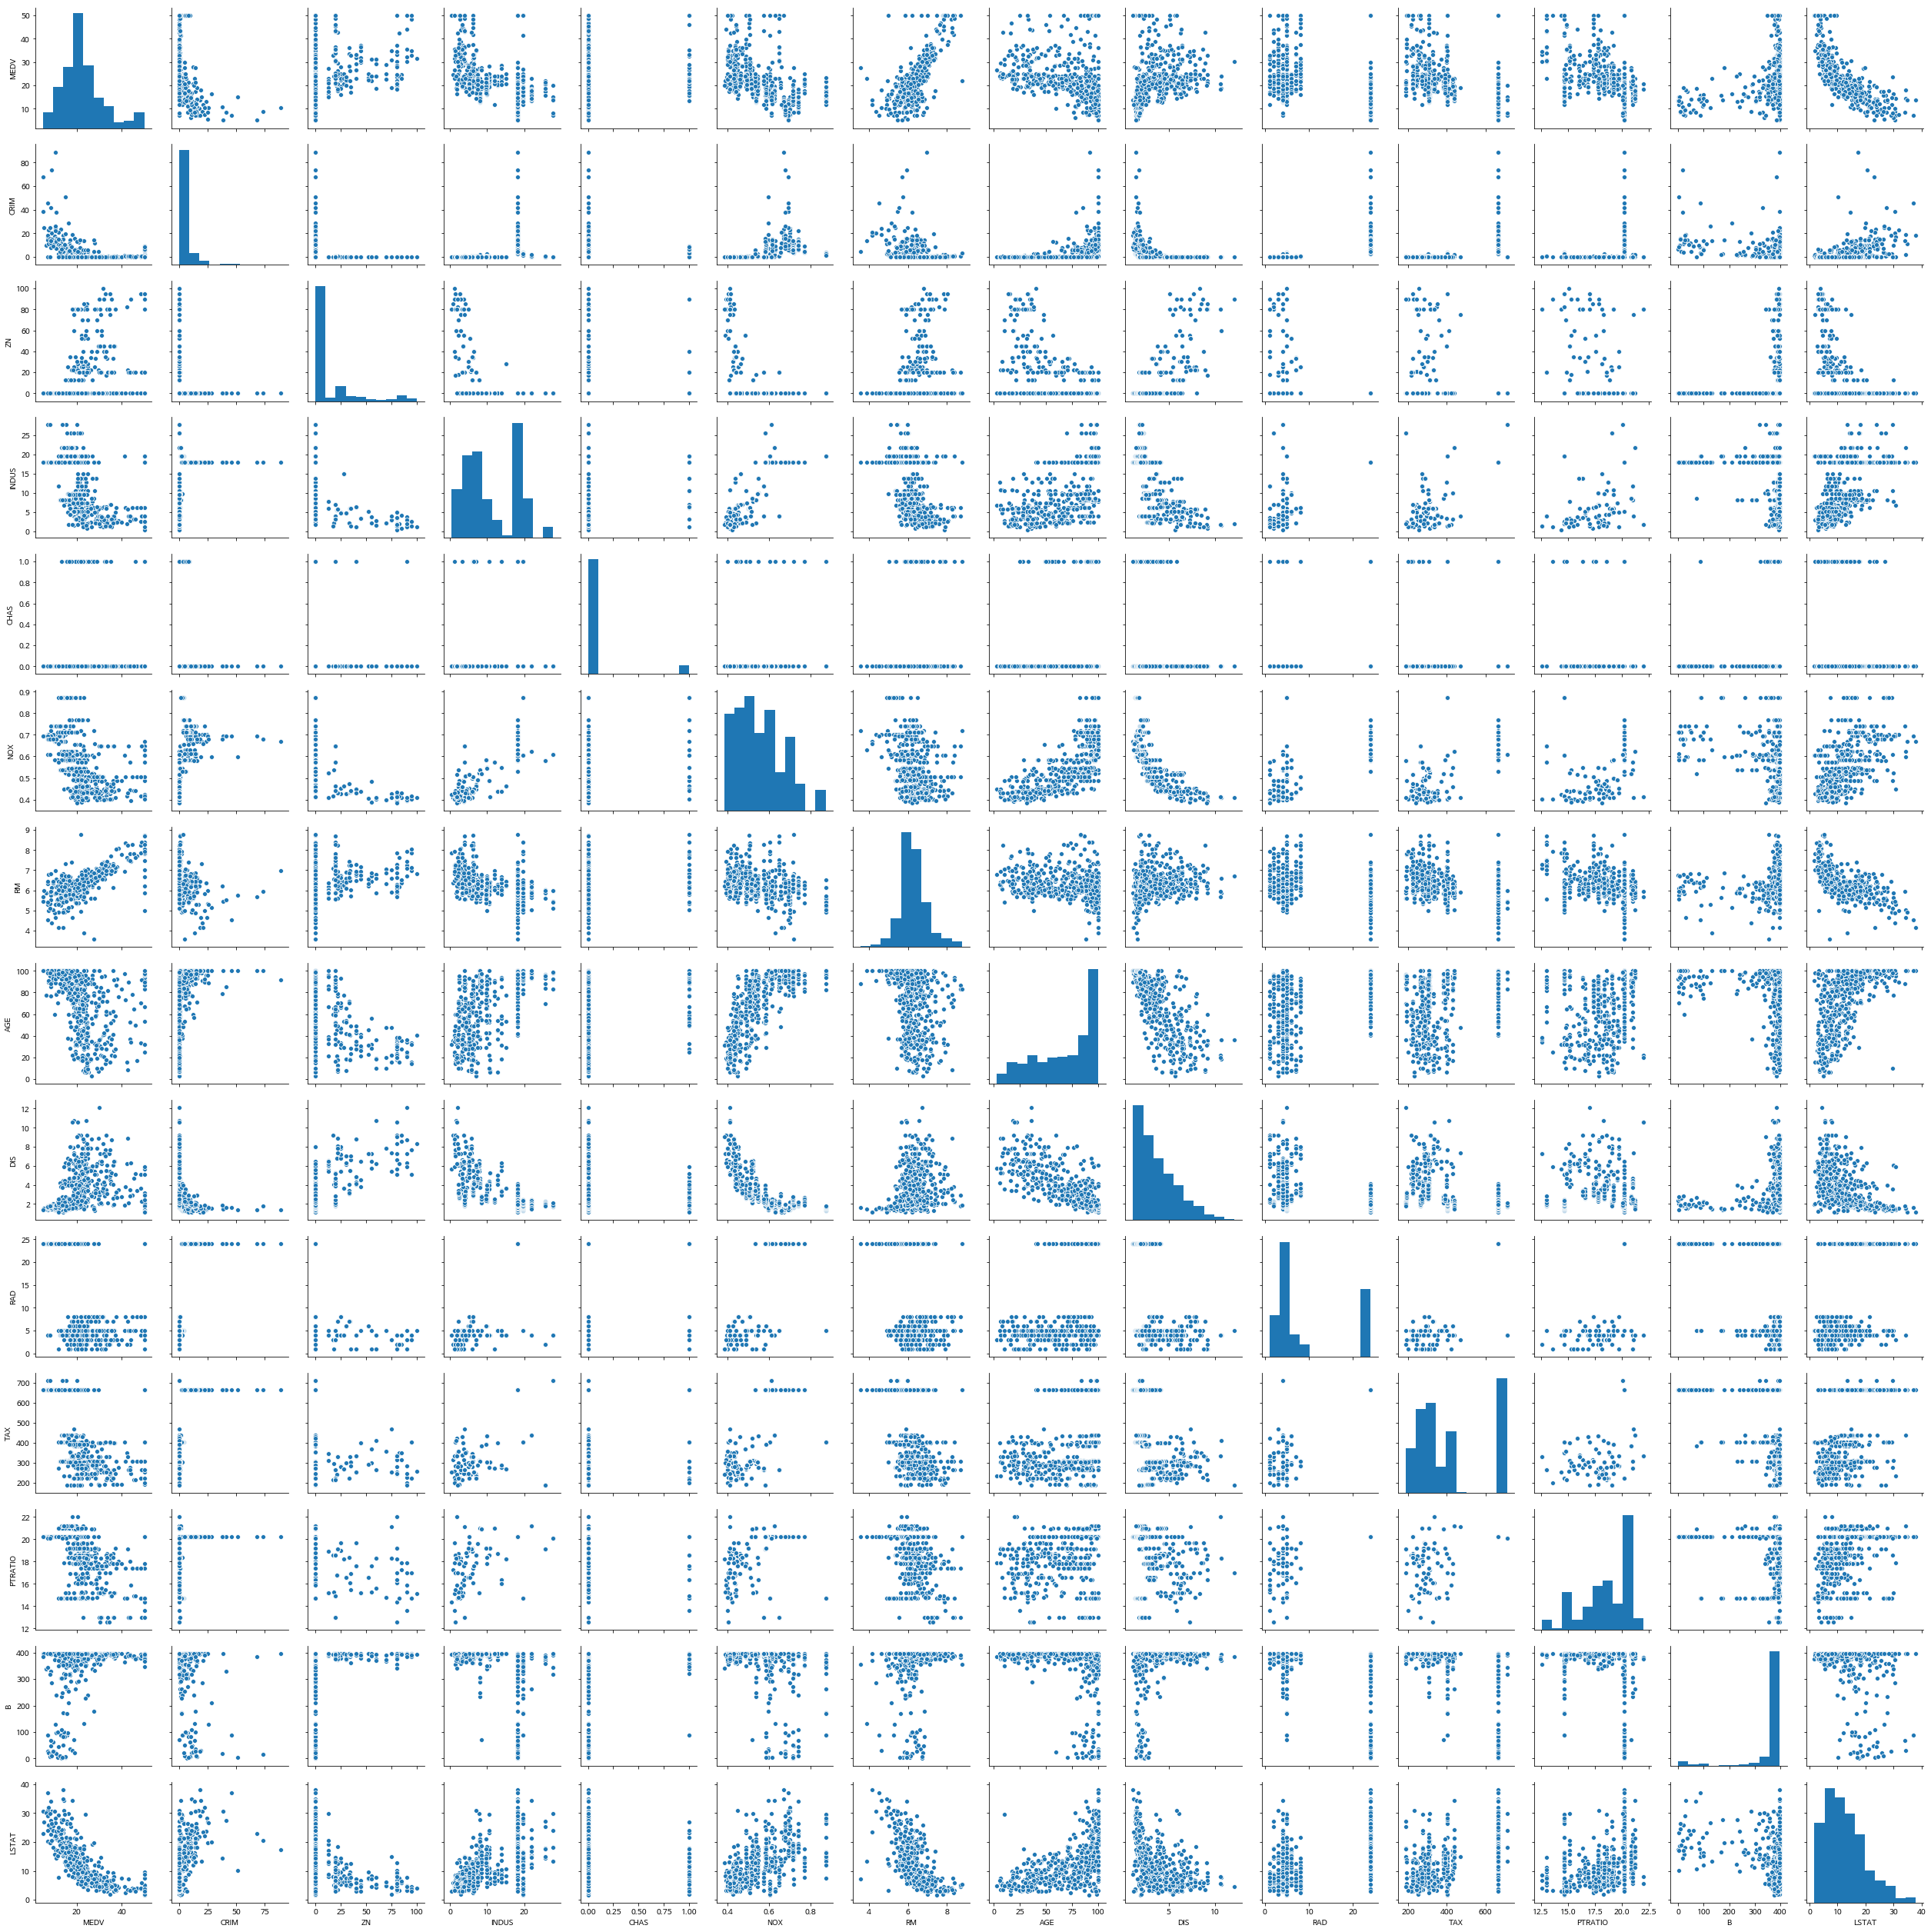

In [9]:
sns.pairplot(ds_house)

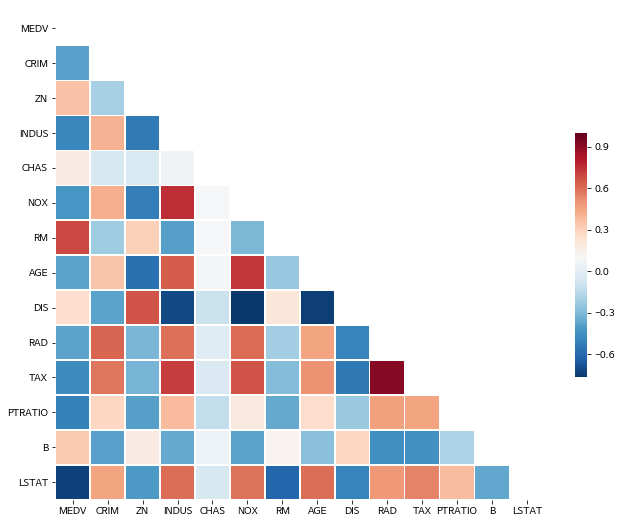

In [24]:
#HeatMap으로 볼 때 더 직관적이다.
#plt.title('variable correlation')
columnNames =list(ds_house.head(0))
corr = ds_house[columnNames[0:]].corr(method='pearson')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ds_house.corr(), mask=mask, cmap="RdBu_r", vmax=1, center=0.1,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
# MEDV
ds_house_highest = pd.DataFrame(ds_house.corr()["MEDV"].sort_values(ascending = False)).reset_index()
for i in range(ds_house_highest.shape[0]):
    if 0.5 < abs(ds_house_highest["MEDV"][i]) < 1:
        print(ds_house_highest["index"][i])

RM
PTRATIO
LSTAT
